In [1]:
%matplotlib inline 
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import spearmanr

In [4]:
from access_biology_data import meta, relations, annotation, properties
from access_literature_data import medline
from access_science_shared import standardizer

import sys
sys.path.append('./../src/')
from aging_tools import inout, export, calculators
from access_aging_data import chaperome, earlier_studies, sequencing


In [5]:
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

In [6]:
outfolder = '191028_hagr_ratio_for_short_and_long_genes'
mode = 'validated_RNA'
percentages = 10

In [7]:
save_images = True

In [8]:
quanta = 0.01 * percentages

agg = []
for taxon_id in [9606, 10090]:

    ref_genes = standardizer.reference_genes(taxon_id, 'orp')  # only consider supported protein coding-genes

    if mode == 'validated_RNA':
        pr = properties.genbank_validated_rna(taxon_id)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
            'Genbank_validated_RNA: full_SumACGT': 'length'
        })
    elif mode == 'gene':
        pr = properties.genbank_gene(taxon_id)[['gene_ncbi', 'Genbank__gene: SumACGT']].rename(columns={
                'Genbank__gene: SumACGT': 'length'
            })
    else:
        raise AssertionError('Something wrong')
    pr.loc[:, 'log_length'] = np.log10(pr['length'])
    pr = pr[pr['gene_ncbi'].isin(ref_genes)]
    pr.loc[:, 'rank'] = pr['length'].rank(pct=True)




    painter = []
    hagr = earlier_studies.hagr_mapped_summary(taxon_id)

    mutant = hagr[hagr['influence'].isin(['anti_longevity'])]
    painter_patch = mutant[['gene_ncbi']].reset_index(drop=True)
    painter_patch.loc[:, 'annotation'] = 'anti_longevity'
    painter.append(painter_patch)

    mutant = hagr[hagr['influence'].isin(['pro_longevity'])]
    painter_patch = mutant[['gene_ncbi']].reset_index(drop=True)
    painter_patch.loc[:, 'annotation'] = 'pro_longevity'
    painter.append(painter_patch)

    painter = pd.concat(painter)

    background = pr['gene_ncbi']

    a = calculators.functional_ratio(
            significant_genes= pr[pr['rank']<quanta]['gene_ncbi'],
            background=background,
            painter=painter,
            test='difference')
    a.loc[:, 'taxon_id'] = taxon_id
    a.loc[:, 'genes'] = 'shortest'
    agg.append(a)
    
    a = calculators.functional_ratio(
            significant_genes= pr[pr['rank']>(1-quanta)]['gene_ncbi'],
            background=background,
            painter=painter,
            test='difference')
    
    a.loc[:, 'taxon_id'] = taxon_id
    a.loc[:, 'genes'] = 'longest'
    agg.append(a)

In [9]:
h = pd.concat(agg)

In [10]:
h = h.reset_index()

In [11]:
h[h['genes']=='longest']

,annotation,fold_enrichment,pvalue,bonferroni,benjamini_hochberg,in_significant,in_background,taxon_id,genes
2,anti_longevity,-0.468542,0.00291178,0.00582356,0.00582356,30,417,9606,longest
3,pro_longevity,0.477228,0.00782373,0.0156475,0.00782373,37,267,9606,longest
6,anti_longevity,-0.413904,0.0138227,0.0276454,0.0220079,27,307,10090,longest
7,pro_longevity,0.449448,0.0220079,0.0440157,0.0220079,32,200,10090,longest


In [12]:
h[h['genes']=='longest']

,annotation,fold_enrichment,pvalue,bonferroni,benjamini_hochberg,in_significant,in_background,taxon_id,genes
2,anti_longevity,-0.468542,0.00291178,0.00582356,0.00582356,30,417,9606,longest
3,pro_longevity,0.477228,0.00782373,0.0156475,0.00782373,37,267,9606,longest
6,anti_longevity,-0.413904,0.0138227,0.0276454,0.0220079,27,307,10090,longest
7,pro_longevity,0.449448,0.0220079,0.0440157,0.0220079,32,200,10090,longest


In [13]:
h[h['genes']=='shortest']['fold_enrichment']

0    0.414389
1    -1.07485
4    0.357984
5   -0.808049
Name: fold_enrichment, dtype: object

In [14]:
h.loc[:, 'joined_label'] = h.loc[:, 'genes'] + '_' + h.loc[:, 'annotation']

In [15]:
h = h.sort_values(['genes', 'annotation'])

In [16]:
if save_images:
    export.export_full_frame(
        '{}/{}_{}_stats.csv'.format(outfolder, mode, percentages),
        h,
        save_index=False
    )

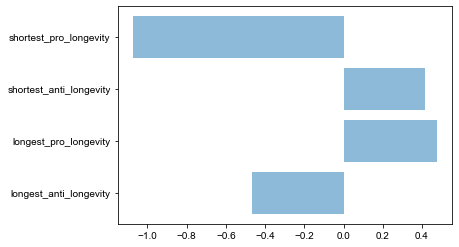

In [17]:
f = h['taxon_id']==9606
v = h[f]['fold_enrichment']
l = h[f]['joined_label']
plt.barh(l, v, align='center', alpha=0.5)

if save_images:
    export.export_image(
        '{}/{}_{}_human.pdf'.format(outfolder, mode, percentages)
    )

In [18]:
h[f]

,annotation,fold_enrichment,pvalue,bonferroni,benjamini_hochberg,in_significant,in_background,taxon_id,genes,joined_label
2,anti_longevity,-0.468542,0.00291178,0.00582356,0.00582356,30,417,9606,longest,longest_anti_longevity
3,pro_longevity,0.477228,0.00782373,0.0156475,0.00782373,37,267,9606,longest,longest_pro_longevity
0,anti_longevity,0.414389,0.000101108,0.000202216,0.000128929,57,417,9606,shortest,shortest_anti_longevity
1,pro_longevity,-1.07485,0.000128929,0.000257858,0.000128929,13,267,9606,shortest,shortest_pro_longevity


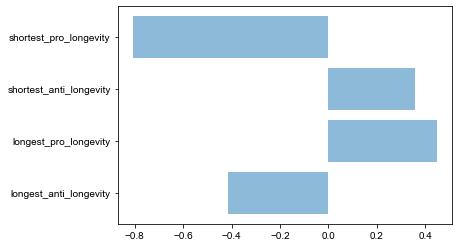

In [19]:
f = h['taxon_id']==10090
v = h[f]['fold_enrichment']
l = h[f]['joined_label']
plt.barh(l, v, align='center', alpha=0.5)

if save_images:
    export.export_image(
        '{}/{}_{}_mouse.pdf'.format(outfolder, mode, percentages)
    )

In [20]:
h[f]

,annotation,fold_enrichment,pvalue,bonferroni,benjamini_hochberg,in_significant,in_background,taxon_id,genes,joined_label
6,anti_longevity,-0.413904,0.0138227,0.0276454,0.0220079,27,307,10090,longest,longest_anti_longevity
7,pro_longevity,0.449448,0.0220079,0.0440157,0.0220079,32,200,10090,longest,longest_pro_longevity
4,anti_longevity,0.357984,0.0243543,0.0487086,0.0262428,31,307,10090,shortest,shortest_anti_longevity
5,pro_longevity,-0.808049,0.0262428,0.0524857,0.0262428,9,200,10090,shortest,shortest_pro_longevity
